In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re

#scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/LoansTrainingSetV2.csv')

C:\Users\agust\AppData\Local\Temp\ipykernel_36036\403483046.py:1: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/LoansTrainingSetV2.csv')


In [3]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [4]:
df.shape

(111105, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111105 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111105 non-null  object 
 1   Customer ID                   111105 non-null  object 
 2   Loan Status                   111105 non-null  object 
 3   Current Loan Amount           111105 non-null  int64  
 4   Term                          111105 non-null  object 
 5   Credit Score                  89767 non-null   float64
 6   Years in current job          106412 non-null  object 
 7   Home Ownership                111105 non-null  object 
 8   Annual Income                 89767 non-null   float64
 9   Purpose                       111105 non-null  object 
 10  Monthly Debt                  111105 non-null  object 
 11  Years of Credit History       111105 non-null  float64
 12  Months since last delinquent  52102 non-null

The datatypes seems fine. However, I need to inspect Years in current job, Monthly Debt, and Maximum Open Credit column. From my point of view, they shouldn't be object.

In [6]:
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens
count,1.111050e+05,89767.000000,8.976700e+04,111105.000000,52102.00000,111105.000000,111105.000000,1.111050e+05,110877.000000,111094.000000
mean,1.147739e+07,1075.662036,7.248528e+04,18.201012,34.90223,11.125044,0.168021,1.548308e+04,0.117662,0.029354
std,3.185533e+07,1473.879929,5.593131e+04,7.014530,21.97033,5.010288,0.484210,1.982133e+04,0.351423,0.260577
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,8.162000e+03,705.000000,4.468700e+04,13.500000,16.00000,8.000000,0.000000,5.905000e+03,0.000000,0.000000
50%,1.418300e+04,724.000000,6.175200e+04,16.900000,32.00000,10.000000,0.000000,1.102700e+04,0.000000,0.000000
75%,2.382200e+04,741.000000,8.688700e+04,21.700000,51.00000,14.000000,0.000000,1.933800e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.00000,76.000000,15.000000,1.730472e+06,7.000000,15.000000


In [7]:
df.isnull().sum()

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                    21338
Years in current job             4693
Home Ownership                      0
Annual Income                   21338
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    59003
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      228
Tax Liens                          11
dtype: int64

There are 6 columns with missing values. The column Months since last delinquent has the most missing values, and it might be problematic. It's followed by Credit Score and Annual Income. I need to see what the data looks like before deciding which strategy I should implement for data imputation.

# EDA

Before imputing the missing data, I will perform EDA to understand the data better. First of all, I will convert the column names into snake case to make it easier to call later.

I will start with the EDA for single variables.

In [8]:
def clean_columns(column_list):
    all_cols = column_list
    
    modified_list = []

    for item in all_cols:
        item = str(item).lower()
        modified_item = re.sub(r'[^a-zA-Z0-9]', '_', item)
        modified_list.append(modified_item)
    
    final_list = []
    
    for i in modified_list:
        cleaned_column_name = re.sub(r'_+', '_', i)
        final_list.append(cleaned_column_name)
    
    final_list = [col.strip('_') for col in final_list]
        
    return final_list

In [129]:
df.columns = clean_columns(df.columns.tolist())

In [10]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [66]:
def create_bar_chart(df,col,rotation=0):
    value_counts_series = df[col].value_counts()

    # Create a bar chart using Seaborn
    sns.barplot(x=value_counts_series.index, y=value_counts_series.values)

    # Add labels and title
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Count')
    plt.title('Distribution of ' + col.replace('_',' ').title())

    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show();

In [50]:
def create_histogram(df,col):
    plt.hist(df[col])
    plt.title('Histogram of ' + col.replace('_',' ').title())
    plt.show()

### Loan Status
I will check whether there are class imbalances in this column.

In [13]:
df.loan_status.value_counts()

loan_status
Loan Given      85934
Loan Refused    25171
Name: count, dtype: int64

In [17]:
df.loan_status.value_counts().index.name

'loan_status'

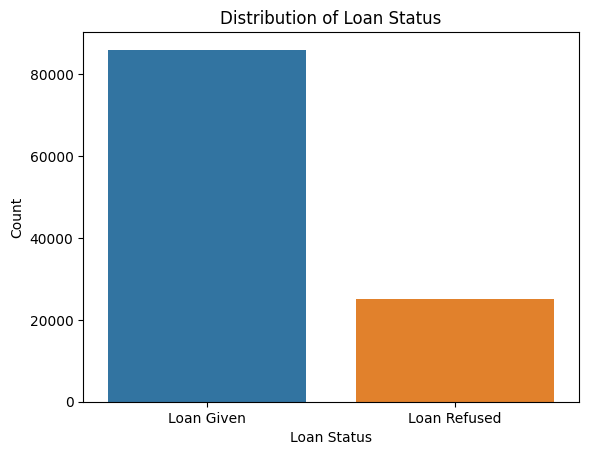

In [67]:
create_bar_chart(df,'loan_status')

According to the bar chart, there is a class imbalance in the loan status column where there are significantly more loan given compared to loan refused.

Next, I'll create a histogram of the current loan amount column to understand the data distribution.

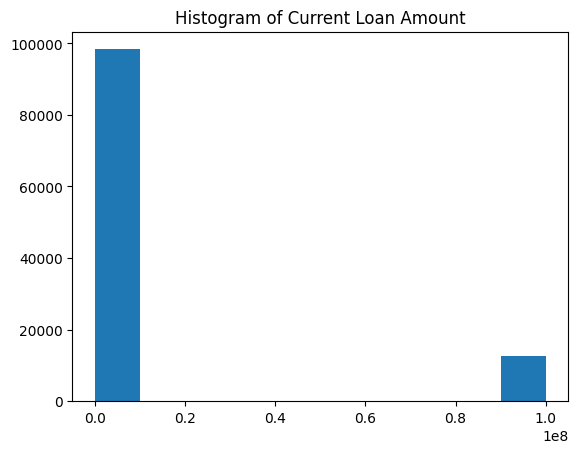

In [53]:
create_histogram(df,'current_loan_amount')

There are extreme values in the histogram, shown by the bar on the far right. The values are:

In [40]:
df[df.current_loan_amount == df.current_loan_amount.max()].head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
5042,bac918fa-35e0-40a2-af65-58b456a742e7,c96da120-30d2-4acd-9740-e4d280f4bfcb,Loan Given,99999999,Short Term,739.0,3 years,Home Mortgage,60012.0,Home Improvements,1295.26,16.6,33.0,16,0,427,8542,0.0,0.0
5043,bb983383-0aa0-4d13-9b7f-05f694672374,d602647a-0820-4025-b93d-9f962f958acf,Loan Given,99999999,Short Term,704.0,9 years,Rent,54802.0,Debt Consolidation,1114.31,16.9,30.0,12,0,4716,5822,0.0,0.0
5044,0c7fcf5e-ec4a-46d5-8175-15c846df7c74,a709e893-b6b6-49ed-b775-bdef1155c78d,Loan Given,99999999,Short Term,751.0,5 years,Rent,35693.0,Debt Consolidation,626.12,11.0,NaN,7,0,742,9166,0.0,0.0
5045,878c4189-bd53-4836-a16d-203519034758,64fa8876-80fa-4a69-b16b-144a8ecfb14a,Loan Given,99999999,Short Term,735.0,NaN,Home Mortgage,33884.0,Debt Consolidation,683.34,18.9,10.0,12,0,10835,18028,0.0,0.0
5046,193ac878-4d50-4be0-995b-20896ebc9ad8,02a4bc6d-db02-406b-9bf6-8e0dd42782eb,Loan Given,99999999,Short Term,745.0,3 years,Own Home,103343.0,Debt Consolidation,1300.41,14.1,NaN,14,0,22746,42835,0.0,0.0


In [29]:
mean_extreme_values = df[df.current_loan_amount == df.current_loan_amount.max()].current_loan_amount.mean()
print(f"The average of the extreme values found in the dataframe is {mean_extreme_values}")

The average of the extreme values found in the dataframe is 99999999.0


The values off all the extreme values are 99999999.0. This indicates that there are errors in inputting the data. I will need to deal with this later.

Next, I will create the bar chart of the loan term.

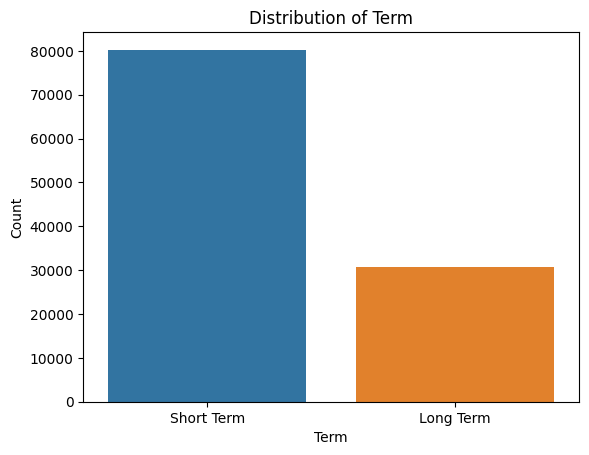

In [68]:
create_bar_chart(df,'term')

Again, there is a class imbalance problem here. But as this is a feature, I will later do a one-hot-encode for this column.

Next, onto the credit score histogram.

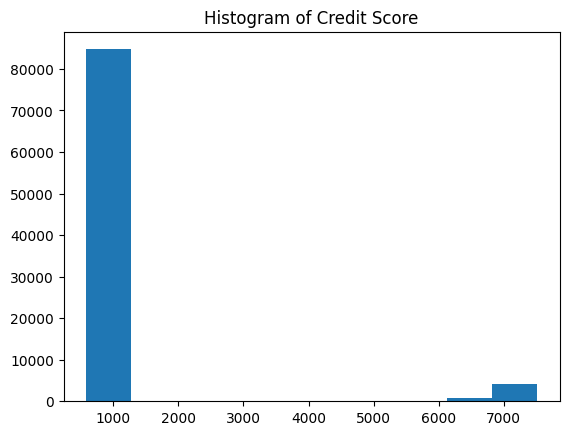

In [55]:
create_histogram(df,'credit_score')

As we can see, there are values that exceed the maximum credit score according to FICO (850). Although there is another method of scoring credit which goes up to 900, I will use FICO as the most common one. I will take a look at the data description where the credit score exceeds 850.

In [34]:
df[df.credit_score>850].credit_score.describe()

count    5042.000000
mean     7109.071797
std       306.060537
min      5850.000000
25%      6950.000000
50%      7190.000000
75%      7350.000000
max      7510.000000
Name: credit_score, dtype: float64

The minimum value is 5850 and the maximum value is 7510. Again, this has to be beacuse of errors in inputting the data. I will divide this score by 10, assuming that the errors happened because of inputting an extra 0 in each row.

Next, I will take a look at the distribution of years in current job.

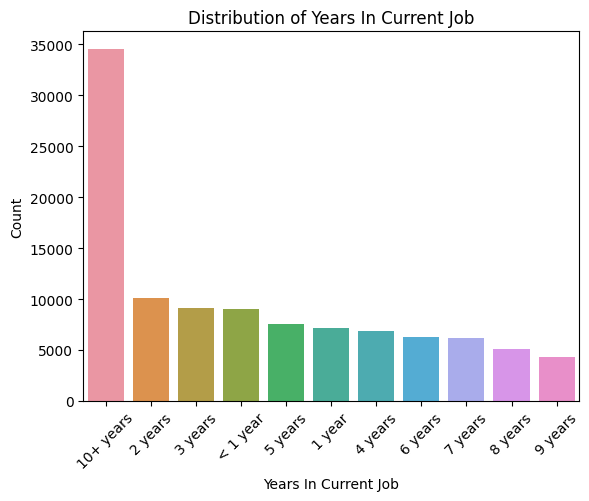

In [69]:
create_bar_chart(df,'years_in_current_job', rotation=45)

Most of the people applying for loan have work 10+ years in their respective companies. The data type is string, because there are special characters and the word 'year(s)'. I will map this into numbers, but treat it as categorical data. 

Next, I will look at the distribution of home ownership.

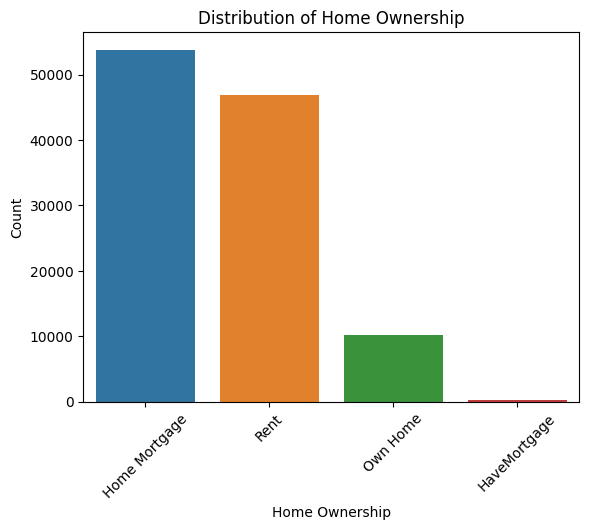

In [70]:
create_bar_chart(df,'home_ownership', rotation=45)

I think the values "Home Mortgage" and "HaveMortgage" is the same. I will have to change it accordingly in the data cleaning phase.

Next, I will examine the distribution of annual income.

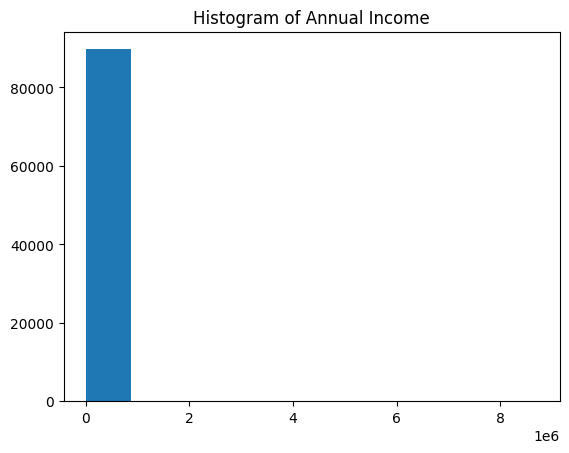

In [58]:
create_histogram(df,'annual_income')

There seems to be extreme values in the data. I will check whether it's an error or not.

In [59]:
df[df.annual_income == df.annual_income.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
3669,6dfd2f9c-b796-4cb3-8f71-04d6ae8a8f92,ceee183a-9b02-4b82-ae53-14ccd5f785fd,Loan Refused,8006,Short Term,7250.0,10+ years,Home Mortgage,8713547.0,Debt Consolidation,798.74,16.0,NaN,11,0,16462,30429,0.0,0.0


I'm not really sure whether this is an error or not. I would say it's possible for someone to have an annual income of USD 8M+ (assuming that the annual income is in USD). And since the purpose of the loan is debt consolidation, it's probable that this person uses debt to finance the business. Therefore, I will not change it and assume that this data is correct.

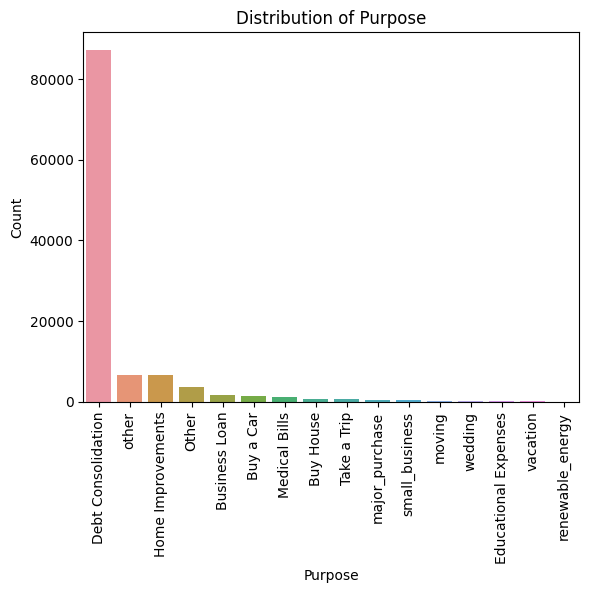

In [71]:
create_bar_chart(df,'purpose', rotation=90)

The majority of people applied for loans with the purpose of debt consolidation. One thing to note here, the data is written using 2 styles: Title and Snake Case. I will convert all the values in columns with string values into snake case, especially for the ones I need to do one-hot-encoding. 

Before moving on the the monthly_debt, I need to check why the column has object values instead of float (as I mentioned before).

In [81]:
data_list = df.monthly_debt.tolist()
data_list_numeric = pd.to_numeric(data_list, errors='coerce')
non_numeric_indices = [index for index, item in enumerate(data_list_numeric) if pd.isna(item)]
for idx in non_numeric_indices:
    print(data_list[idx])

$1051.41
$157.15
$944.7
$481.34
$1838.98
$471.6


Apparently, the monthly_debt column has a dollar symbol on some of the values. Before proceeding to build the histogram, I need to fix this and change the datatype into float.

In [107]:
data_float = []
for i in data_list:
    try:
        flt_data = float(i)
    except:
        flt_data = float(i.strip().replace('$',''))
    data_float.append(flt_data)

In [116]:
data_list_numeric = pd.to_numeric(data_float, errors='coerce')
non_numeric_indices = [index for index, item in enumerate(data_float) if pd.isna(item)]
print(f"There are {len(non_numeric_indices)} non-numeric data")

There are 0 non-numeric data


In [113]:
df['monthly_debt'] = data_float

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111105 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   loan_id                       111105 non-null  object 
 1   customer_id                   111105 non-null  object 
 2   loan_status                   111105 non-null  object 
 3   current_loan_amount           111105 non-null  int64  
 4   term                          111105 non-null  object 
 5   credit_score                  89767 non-null   float64
 6   years_in_current_job          106412 non-null  object 
 7   home_ownership                111105 non-null  object 
 8   annual_income                 89767 non-null   float64
 9   purpose                       111105 non-null  object 
 10  monthly_debt                  111105 non-null  float64
 11  years_of_credit_history       111105 non-null  float64
 12  months_since_last_delinquent  52102 non-null

Now, the monthly_debt has the correct datatype. I will plot the histogram.

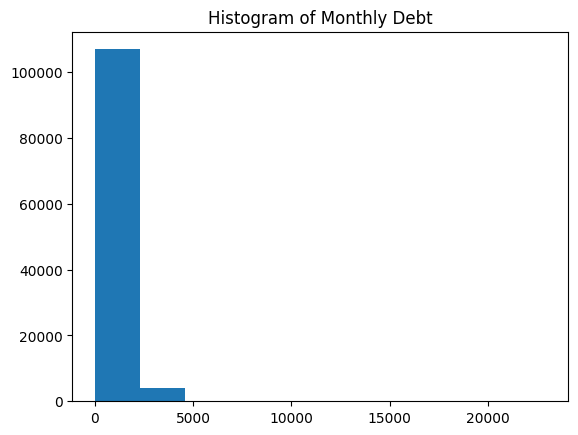

In [117]:
create_histogram(df,'monthly_debt')

There seems to be extreme values as well in this data. Let's check the data description of people with monthly debt larger than the 75% quantile.

In [123]:
df[df.monthly_debt > df.monthly_debt.describe()['75%']].monthly_debt.describe()

count    27775.000000
mean      1821.517244
std        625.113477
min       1262.720000
25%       1416.895000
50%       1636.520000
75%       2011.140000
max      22939.120000
Name: monthly_debt, dtype: float64

The extreme values are still present. Let's check whether it's still present if the monthly debt is larger than 10000.

In [125]:
df[df.monthly_debt >10000].monthly_debt

4010     10831.65
18580    12055.68
79752    22939.12
89940    12055.68
Name: monthly_debt, dtype: float64

Apparently, the extreme values are just present without errors. It's possible that some people have high monthly debt to be paid. Therefore, I won't do anything to this column as well.

In [134]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


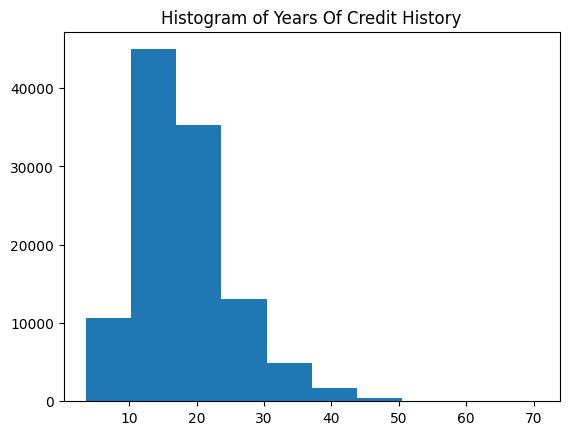

In [135]:
create_histogram(df,'years_of_credit_history')

The distribution is skewed to the right. The number of people with 10 to about 18 years in credit history is the most compared to the other bins.

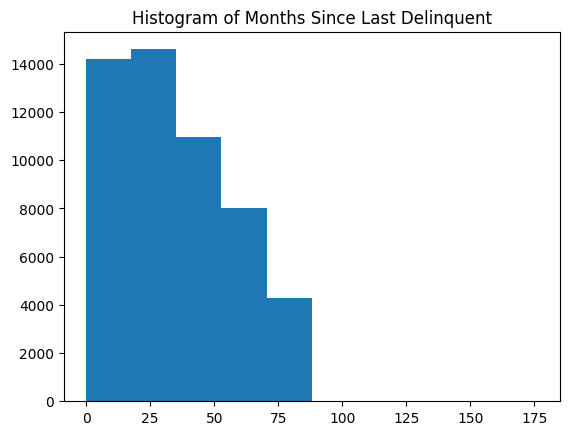

In [137]:
create_histogram(df,'months_since_last_delinquent')

In [138]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [139]:
df.bankruptcies.value_counts()

bankruptcies
0.0    98648
1.0    11613
2.0      468
3.0      110
4.0       27
5.0        8
6.0        2
7.0        1
Name: count, dtype: int64

## Examining duplicates

The crucial columns that cannot have duplicates is Loan ID. If it has duplicates, it indicates double input because ID needs to be unique. Furthermore, for every Loan ID, there can only be one customer. If there are 2 or more customers with the same Loan ID, it indicates that there are errors in inputting the data. These needs to be dropped. 

Before examining the duplicates, I will convert the column names into snake case to make it easier to call later.

In [ ]:
def clean_columns(column_list):
    all_cols = column_list
    
    modified_list = []

    for item in all_cols:
        item = str(item).lower()
        modified_item = re.sub(r'[^a-zA-Z0-9]', '_', item)
        modified_list.append(modified_item)
    
    final_list = []
    
    for i in modified_list:
        cleaned_column_name = re.sub(r'_+', '_', i)
        final_list.append(cleaned_column_name)
    
    final_list = [col.strip('_') for col in final_list]
        
    return final_list

In [ ]:
df.columns = clean_columns(df.columns.tolist())

In [ ]:
df.head()

In [ ]:
duplicate_rows = df[df.duplicated(subset=['loan_id'], keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by='loan_id')

In [ ]:
duplicate_rows_sorted.head(20)

In [ ]:
duplicate_rows.shape

In [ ]:
df.shape

In [ ]:
#checking whether there are double customer_ids for every loan_id
count_different_customer_ids = duplicate_rows_sorted.groupby('loan_id')['customer_id'].nunique()
count_different_customer_ids = count_different_customer_ids[count_different_customer_ids > 1]
print(f'There are {len(count_different_customer_ids)} duplicated customers for every loan_id')

There are no duplicated customers for every loan_id. Therefore, I need to just group the loan_id and take the non-null values and non-extreme values. For example, if we see the rows below:

In [ ]:
df[df['loan_id'] == '000ea0cb-8d0e-4284-b8c8-444ffbbe4caf']

the correct current_loan_amount should be 21075 instead of 99999999.

In [ ]:
def handle_value(values):
    non_nan_values = [value for value in values if not pd.isna(value)]
    if any(isinstance(value, str) for value in non_nan_values):
        return non_nan_values[0]  # Return the first non-NaN string value
    else:
        non_extreme_values = [value for value in non_nan_values if value != 99999999]
        return non_extreme_values[0] if non_extreme_values else np.nan

In [ ]:
df.columns

In [ ]:
df_agg = df.groupby('loan_id').agg(handle_value).reset_index()

In [ ]:
df_agg[df_agg['loan_id'].duplicated()]

Now that I've handled the duplicated rows, I will perform imputations on each column.

In [ ]:
df.isnull().sum()